Experiments notebook (script-style cells).  
This file is intended to be opened as a Jupyter notebook (e.g. VSCode/Open in Jupyter).

Steps implemented:
1) import utilities
2) generate representative scenarios (one per kind) and visualize them in a 2x2 grid
3) run both schedulers on multiple tests per kind and produce 4 summary tables (avg & worst) with highlights
4) save generated tests to ./tests

Notes
- Requires: numpy, matplotlib, pandas, scikit-learn, scipy
- Local modules required: model.py, generators.py, heuristics.py (in same PYTHONPATH)

In [1]:
import os
from pathlib import Path
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from generators import (
    GenParams,
    generate_scenario,
    generate_suite,
    scenario_to_json_dict,
    save_scenarios_json,
)
from heuristics import schedule_nn, schedule_clustered_nn

# matplotlib styling for colorblind-friendly palettes
CB_CMAP = plt.get_cmap("tab10")  # generally colorblind-friendly qualitative colormap

# Directory to save tests
TEST_DIR = Path("./tests")
TEST_DIR.mkdir(parents=True, exist_ok=True)

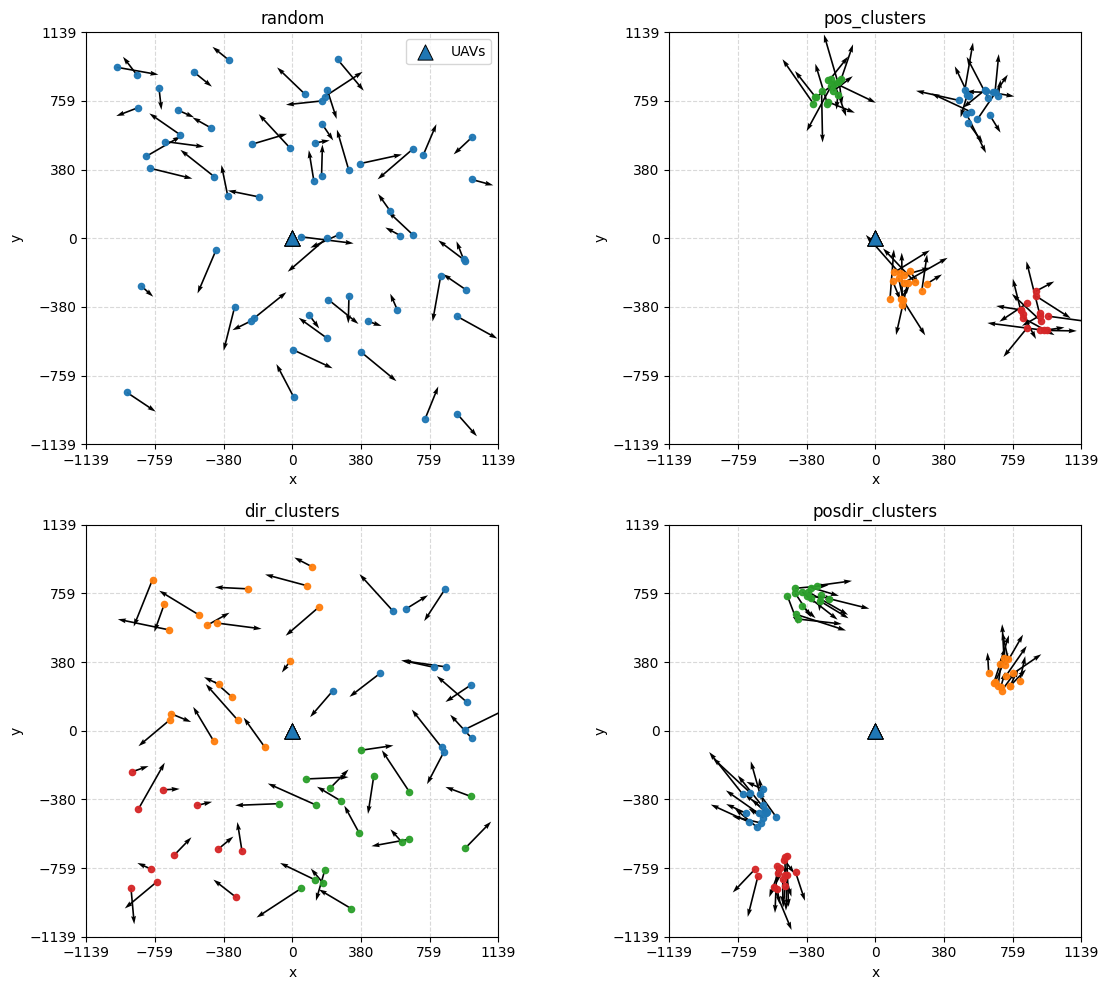

In [7]:
# 2) Generate representative scenarios and visualize (2x2)
cases = ["random", "pos_clusters", "dir_clusters", "posdir_clusters"]
rep_params = GenParams(n_targets=60, n_uavs=4, cluster_pos_radius=120.0)

# generate one representative scenario per case with fixed seeds so figures are reproducible
rep_scenarios = [generate_scenario(case, rep_params, seed=100 + i, scenario_id=f"rep_{case}") for i, case in enumerate(cases)]

# Compute global plotting bounds so all subplots share the same scale
all_x = []
all_y = []
for sc in rep_scenarios:
    for t in sc.targets:
        all_x.append(float(t.p0[0])); all_y.append(float(t.p0[1]))
    for u in sc.uavs:
        all_x.append(float(u.p0[0])); all_y.append(float(u.p0[1]))

if all_x and all_y:
    xmax = ymax = max(max(all_x + all_y), -min(all_x + all_y))
    xmin = ymin = -xmax
else:
    xmin, xmax = -1.0, 1.0
    ymin, ymax = -1.0, 1.0

xrange = xmax - xmin if xmax > xmin else 1.0
yrange = ymax - ymin if ymax > ymin else 1.0
max_range = max(xrange, yrange)
margin = 0.07 * max_range
plot_xlim = (xmin - margin, xmax + margin)
plot_ylim = (ymin - margin, ymax + margin)

# Compute arrow scaling from overall speed range so arrows are visible but not overwhelming
all_speeds = []
for sc in rep_scenarios:
    for t in sc.targets:
        all_speeds.append(float(np.linalg.norm(t.v)))
max_speed = max(1.0, max(all_speeds) if all_speeds else 1.0)
# make the largest arrow about ~15% of the plot max_range
arrow_scale = 0.15 * max_range / max_speed

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, case, sc in zip(axes, cases, rep_scenarios):
    ax.set_title(case)

    # plot UAVs (single scatter call, no per-UAV labels)
    u_pts = np.array([u.p0 for u in sc.uavs])
    if u_pts.size > 0:
        ax.scatter(u_pts[:, 0], u_pts[:, 1], marker="^", s=120, edgecolor="k", linewidth=0.7, label="UAVs", zorder=4)

    # plot targets and velocity arrows
    pts = np.array([t.p0 for t in sc.targets])
    vels = np.array([t.v for t in sc.targets])

    # For clustered-looking cases, color by kmeans (for visualization only)
    if case in ("pos_clusters", "posdir_clusters", "dir_clusters") and len(pts) >= min(len(sc.targets), len(sc.uavs)):
        from sklearn.cluster import KMeans
        k = min(len(sc.targets), len(sc.uavs))
        km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(pts)
        labels = km.labels_
    else:
        labels = np.zeros(len(sc.targets), dtype=int)

    # plot points colored by label (use colorblind-friendly colormap)
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        mask = labels == lab
        ax.scatter(pts[mask, 0], pts[mask, 1], s=20, color=CB_CMAP(lab % 10), alpha=0.95, zorder=3)

    # draw velocity arrows (quiver) scaled for visibility
    if len(pts) > 0:
        u = vels[:, 0] * arrow_scale
        v = vels[:, 1] * arrow_scale
        ax.quiver(pts[:, 0], pts[:, 1], u, v, angles="xy", scale_units="xy", scale=1.0, width=0.004, zorder=2)

    # set shared limits and aspect
    ax.set_xlim(plot_xlim)
    ax.set_ylim(plot_ylim)
    ax.set_aspect("equal", adjustable="box")

    # add lightly greyed grid with a reasonable number of ticks for quick coordinate reading
    nx = 7
    xticks = np.linspace(plot_xlim[0], plot_xlim[1], nx)
    yticks = np.linspace(plot_ylim[0], plot_ylim[1], nx)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.grid(True, which='major', color='0.85', linestyle='--')

    ax.set_xlabel("x")
    ax.set_ylabel("y")

# tidy legend: show UAV marker only once
axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

In [12]:
# 3) Run batched experiments and summarize results
# Parameters
N_PER_CASE = 30  # number of random scenarios per case for statistics (adjust if heavy)
BASE_PARAMS = GenParams(n_targets=30, n_uavs=4, cluster_pos_radius=80.0)
MASTER_SEED = 12345

# generate test suite: uses generate_suite which returns a list of Scenario
suite = generate_suite(cases=cases, n_per_case=N_PER_CASE, base_params=BASE_PARAMS, seed=MASTER_SEED, id_prefix="exp")

# Save full suite to disk
save_path = TEST_DIR / "generated_suite.json"
save_scenarios_json(str(save_path), suite, indent=2)
print(f"Saved {len(suite)} scenarios to: {save_path}")

# Run solvers on all scenarios and collect metrics
records = []
for sc in suite:
    # determine case from metadata if present, otherwise parse id
    case = sc.metadata.get("case", sc.id.split("_")[1] if "_" in sc.id else "unknown")

    # schedule_nn
    rep_nn = schedule_nn(sc)
    records.append({
        "case": case,
        "scenario_id": sc.id,
        "solver": "nn",
        "total_distance": float(rep_nn.total_distance),
        "makespan": float(rep_nn.makespan),
        "success": bool(rep_nn.success),
        "n_unreached": len(rep_nn.unreached_targets),
    })

    # clustered
    rep_cl = schedule_clustered_nn(sc, seed= int(sc.metadata.get("seed") or 0))
    records.append({
        "case": case,
        "scenario_id": sc.id,
        "solver": "clustered_nn",
        "total_distance": float(rep_cl.total_distance),
        "makespan": float(rep_cl.makespan),
        "success": bool(rep_cl.success),
        "n_unreached": len(rep_cl.unreached_targets),
    })

# create DataFrame
df = pd.DataFrame.from_records(records)

# Show head
print(df.head())

# For each case produce a summary table comparing the two solvers
summary_tables = {}
for case in cases:
    df_case = df[df["case"] == case]
    rows = []
    for solver in ["nn", "clustered_nn"]:
        dsub = df_case[df_case["solver"] == solver]
        # Only consider successful runs when computing avg/worst; also report failures
        succ = dsub[dsub["success"]]
        fail_count = len(dsub) - len(succ)
        avg_total = succ["total_distance"].mean() if len(succ) > 0 else float("nan")
        worst_total = succ["total_distance"].max() if len(succ) > 0 else float("nan")
        avg_makespan = succ["makespan"].mean() if len(succ) > 0 else float("nan")
        worst_makespan = succ["makespan"].max() if len(succ) > 0 else float("nan")
        rows.append({
            "solver": solver,
            "avg_total_distance": avg_total,
            "worst_total_distance": worst_total,
            "avg_makespan": avg_makespan,
            "worst_makespan": worst_makespan,
            "n_runs": len(dsub),
            "n_failures": fail_count,
        })
    summary = pd.DataFrame(rows).set_index("solver")

    # Add comparative advantage columns (clustered minus nn)
    # We'll compute advantage of the better solver vs the other for each metric
    def advantage(metric):
        a = summary.loc["nn", metric]
        b = summary.loc["clustered_nn", metric]
        if math.isnan(a) or math.isnan(b):
            return "n/a"
        if a < b:
            return ("nn", float(b - a))
        else:
            return ("clustered_nn", float(a - b))

    adv_total = advantage("avg_total_distance")
    adv_makespan = advantage("avg_makespan")

    summary_tables[case] = {"table": summary, "advantage_avg_total": adv_total, "advantage_avg_makespan": adv_makespan}

# Display results nicely as pandas styled tables
from IPython.display import display as ipydisplay
for case in cases:
    tab = summary_tables[case]["table"].copy()

    # Round numeric columns to 2 decimals for concise presentation
    num_cols = ["avg_total_distance", "worst_total_distance", "avg_makespan", "worst_makespan"]
    for c in num_cols:
        if c in tab.columns:
            tab[c] = tab[c].round(2)

    # Compute percentage advantage for avg metrics: relative improvement of the better solver
    def pct_advantage(a, b):
        # returns (winner_name, percent_adv) or ("n/a", None) if not computable
        if pd.isna(a) or pd.isna(b) or (a == 0 and b == 0):
            return ("n/a", None)
        if a < b:
            # a is better (smaller)
            pct = (b - a) / b * 100.0 if b != 0 else float("inf")
            return ("nn", pct)
        elif b < a:
            pct = (a - b) / a * 100.0 if a != 0 else float("inf")
            return ("clustered_nn", pct)
        else:
            return ("tie", 0.0)

    a_avg_total = summary_tables[case]["table"].loc["nn", "avg_total_distance"]
    b_avg_total = summary_tables[case]["table"].loc["clustered_nn", "avg_total_distance"]
    winner_t, pct_t = pct_advantage(a_avg_total, b_avg_total)

    a_avg_make = summary_tables[case]["table"].loc["nn", "avg_makespan"]
    b_avg_make = summary_tables[case]["table"].loc["clustered_nn", "avg_makespan"]
    winner_m, pct_m = pct_advantage(a_avg_make, b_avg_make)

    adv_total_str = (f"{winner_t} by {pct_t:.2f}%" if pct_t is not None else "n/a")
    adv_make_str = (f"{winner_m} by {pct_m:.2f}%" if pct_m is not None else "n/a")

    tab["advantage_avg_total_pct"] = adv_total_str
    tab["advantage_avg_makespan_pct"] = adv_make_str

    # Use pandas styling to highlight the better (smaller) average metrics
    sty = tab.style.highlight_min(subset=["avg_total_distance", "avg_makespan"], axis=0, props="background-color: #d5f5d5;")
    sty = sty.set_caption(f"Summary for case: {case}")
    ipydisplay(sty)

Saved 120 scenarios to: tests/generated_suite.json
     case   scenario_id        solver  total_distance      makespan  success   
0  random  exp_random_1            nn    44435.955952  15857.187663     True  \
1  random  exp_random_1  clustered_nn    33974.291308  14751.417215     True   
2  random  exp_random_2            nn    27067.893085  12161.130810     True   
3  random  exp_random_2  clustered_nn    31174.823954  13592.187319     True   
4  random  exp_random_3            nn    13620.142950   4166.193492     True   

   n_unreached  
0            0  
1            0  
2            0  
3            0  
4            0  


,avg_total_distance,worst_total_distance,avg_makespan,worst_makespan,n_runs,n_failures,advantage_avg_total_pct,advantage_avg_makespan_pct
solver,,,,,,,,
nn,32774.070000,55015.350000,13412.120000,25150.570000,30,0,nn by 41.11%,nn by 55.34%
clustered_nn,55654.210000,101369.850000,30034.140000,72178.760000,30,0,nn by 41.11%,nn by 55.34%


,avg_total_distance,worst_total_distance,avg_makespan,worst_makespan,n_runs,n_failures,advantage_avg_total_pct,advantage_avg_makespan_pct
solver,,,,,,,,
nn,30226.450000,57771.000000,10936.280000,21009.300000,30,0,nn by 13.79%,nn by 31.54%
clustered_nn,35062.400000,74058.320000,15973.800000,46837.750000,30,0,nn by 13.79%,nn by 31.54%


,avg_total_distance,worst_total_distance,avg_makespan,worst_makespan,n_runs,n_failures,advantage_avg_total_pct,advantage_avg_makespan_pct
solver,,,,,,,,
nn,35701.330000,67263.550000,14462.950000,38233.260000,30,0,nn by 26.87%,nn by 48.55%
clustered_nn,48818.490000,130271.060000,28109.280000,105056.690000,30,0,nn by 26.87%,nn by 48.55%


,avg_total_distance,worst_total_distance,avg_makespan,worst_makespan,n_runs,n_failures,advantage_avg_total_pct,advantage_avg_makespan_pct
solver,,,,,,,,
nn,35719.660000,154935.210000,13526.870000,73930.350000,30,0,clustered_nn by 62.96%,clustered_nn by 57.41%
clustered_nn,13232.200000,21957.530000,5761.620000,11233.890000,30,0,clustered_nn by 62.96%,clustered_nn by 57.41%


Saved summary tables to tests/summaries


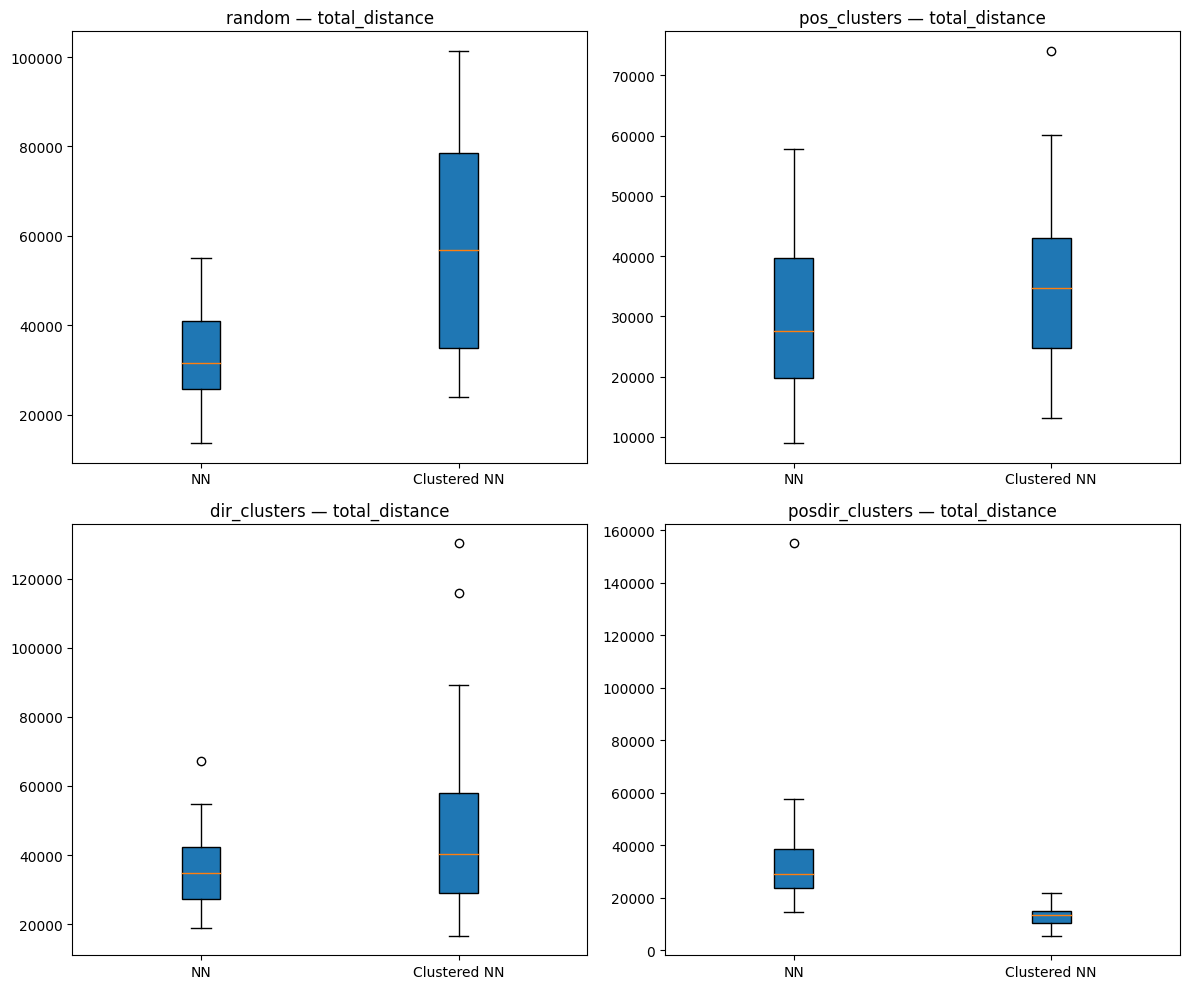

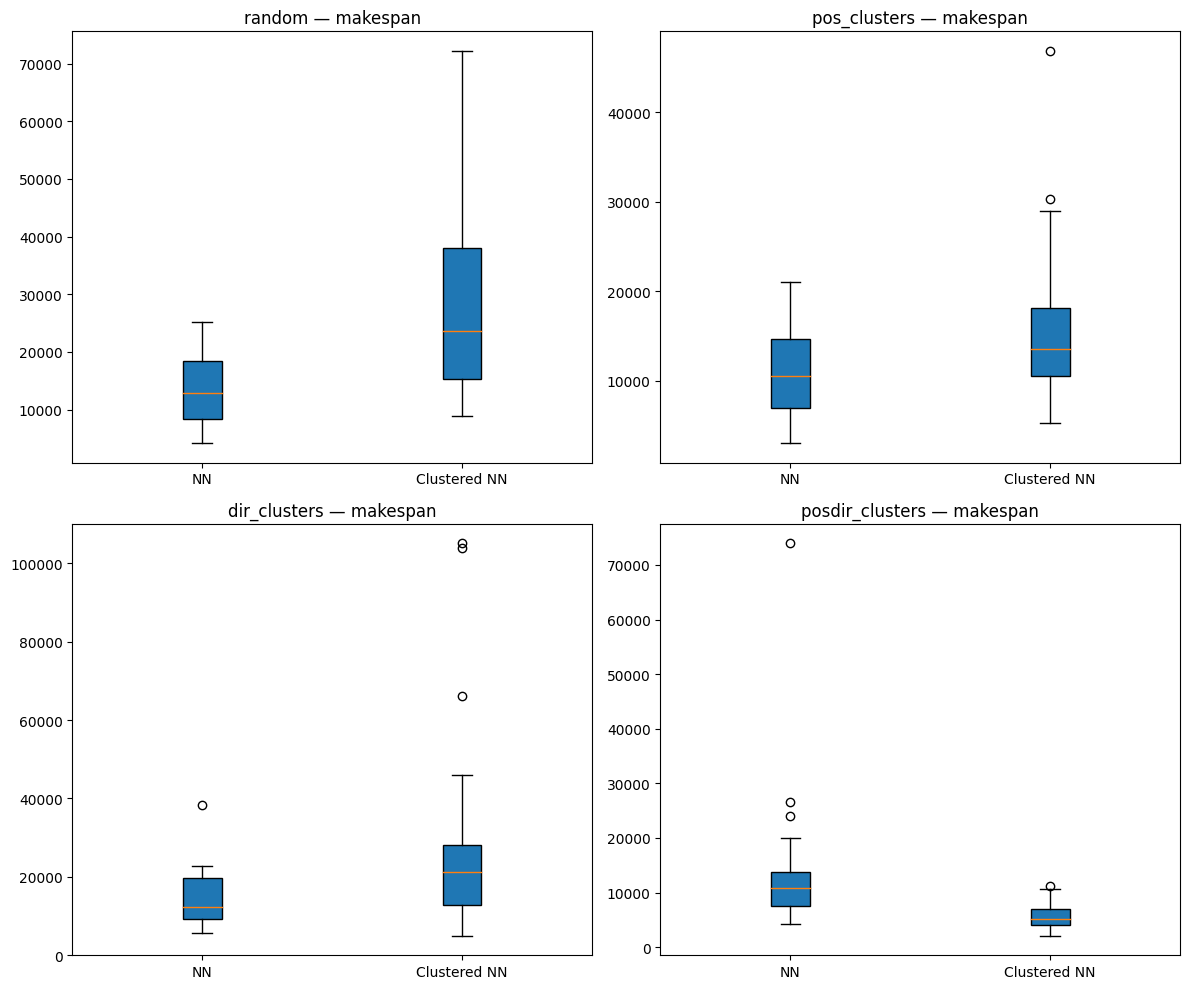

All experiments complete.


In [13]:
# 4) Save per-case tables to CSV for later inspection
OUT_DIR = TEST_DIR / "summaries"
OUT_DIR.mkdir(parents=True, exist_ok=True)
for case in cases:
    tab = summary_tables[case]["table"]
    tab.to_csv(OUT_DIR / f"summary_{case}.csv")

print(f"Saved summary tables to {OUT_DIR}")

# %%
# Quick plots: boxplots comparing solvers for each case (total_distance and makespan)
for metric in ["total_distance", "makespan"]:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()
    for ax, case in zip(axs, cases):
        sub = df[df["case"] == case]
        data_nn = sub[sub["solver"] == "nn"][metric].dropna()
        data_cl = sub[sub["solver"] == "clustered_nn"][metric].dropna()
        ax.boxplot([data_nn.values, data_cl.values], labels=["NN", "Clustered NN"], patch_artist=True)
        ax.set_title(f"{case} — {metric}")
    plt.tight_layout()
    plt.show()

# %%
# Done. The generated scenarios are saved in ./tests/generated_suite.json and summaries in ./tests/summaries
print("All experiments complete.")